In [1]:
#original code https://github.com/enakai00/autoencoder_example

import tensorflow as tf
import os,shutil
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.estimator.model_fn import ModeKeys as Modes
from tensorflow.contrib.learn import Experiment
from tensorflow.contrib.learn.python.learn import learn_runner
from tensorflow.contrib.learn.python.learn.utils import (saved_model_export_utils)

tf.logging.set_verbosity(tf.logging.INFO)

OUTDIR='/tmp/trained_model'

#
# definining queue
#
def read_and_decode(filename_queue):
    reader = tf.TFRecordReader()
    _,serialized_example = reader.read(filename_queue)
    
    features = tf.parse_single_example(
        serialized_example,
        features={
            'image_raw':tf.FixedLenFeature([],tf.string),
            'label':tf.FixedLenFeature([],tf.int64),
        })
    
    image = tf.decode_raw(features['image_raw'],tf.uint8)
    image.set_shape([784]) #image shape is (784,)
    image = tf.cast(image,tf.float32)*(1.0/255)
    label = tf.cast(features['label'],tf.int32)
    
    return image,label

def input_fn(filename,batch_size=100):
    filename_queue = tf.train.string_input_producer([filename])
    
    image,label = read_and_decode(filename_queue)
    images,labels = tf.train.batch(
        [image,label],batch_size=batch_size,
        capacity=1000+3*batch_size)
    #images : (100,784), labels : (100,1)
    
    return {'inputs':images},labels

def get_input_fn(filename,batch_size=100):
    return lambda: input_fn(filename,batch_size)

def serving_input_fn():
    inputs = {'inputs':tf.placeholder(tf.float32,[None,784])}
    return tf.estimator.export.ServingInputReceiver(inputs,inputs)

#
# define model
#
def autoencoder_model_fn(features,labels,mode):
    input_layer = features['inputs']
    dense1 = tf.layers.dense(inputs=input_layer,units=256,activation=tf.nn.relu)
    dense2 = tf.layers.dense(inputs=dense1,units=128,activation=tf.nn.relu)
    dense3 = tf.layers.dense(inputs=dense2,units=16,activation=tf.nn.relu)
    dense4 = tf.layers.dense(inputs=dense3,units=128,activation=tf.nn.relu)
    dense5 = tf.layers.dense(inputs=dense4,units=256,activation=tf.nn.relu)
    output_layer = tf.layers.dense(inputs=dense5,units=784,activation=tf.nn.sigmoid)
    
    #training and evaluation mode
    if mode in (Modes.TRAIN,Modes.EVAL):
        global_step = tf.contrib.framework.get_or_create_global_step()
        label_indices = tf.cast(labels,tf.int32)
        loss = tf.reduce_sum(tf.square(output_layer - input_layer))
        tf.summary.scalar('OptimizeLoss',loss)

        if mode == Modes.TRAIN:
            optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
            train_op = optimizer.minimize(loss,global_step=global_step)
            return tf.estimator.EstimatorSpec(mode,loss = loss, train_op = train_op)
        if mode == Modes.EVAL:
            eval_metric_ops = None
            return tf.estimator.EstimatorSpec(
                mode,loss=loss,eval_metric_ops = eval_metric_ops)
        
    # prediction mode
    if mode == Modes.PREDICT:
        predictions={
            'outputs':output_layer
        }
        export_outputs={
            'outputs':tf.estimator.export.PredictOutput(predictions)
        }
        return tf.estimator.EstimatorSpec(
            mode,predictions=predictions,export_outputs=export_outputs) #이부분 코드 상세 조사할것
    

def build_estimator(model_dir):
    return tf.estimator.Estimator(
        model_fn = autoencoder_model_fn,
        model_dir = model_dir,
        config=tf.contrib.learn.RunConfig(save_checkpoints_secs=180))

def generate_experiment_fn(data_dir,
                          train_batch_size = 100,
                          eval_batch_size = 100,
                          train_steps = 1000,
                          eval_steps = 1,
                          **experiment_args):
    def _experiment_fn(output_dir):
        return Experiment(
            build_estimator(output_dir),
            train_input_fn=get_input_fn('./data/train.tfrecords',batch_size=train_batch_size),
            eval_input_fn=get_input_fn('./data/test.tfrecords',batch_size=eval_batch_size),
            export_strategies = [saved_model_export_utils.make_export_strategy(
                serving_input_fn,
                default_output_alternative_key=None,
                exports_to_keep=1)
            ],
            train_steps = train_steps,
            eval_steps = eval_steps,
            **experiment_args
        )
    return _experiment_fn

shutil.rmtree(OUTDIR, ignore_errors=True) # start fresh each time
learn_runner.run(
    generate_experiment_fn(
        data_dir='./data/',
        train_steps=2000),
    OUTDIR)
    

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 180, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11ba72590>, '_model_dir': '/tmp/trained_model', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_save_summary_steps': 100, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_evaluation_master': '', '_master': ''}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/trained_model/model.ckpt.
INFO:tensorflow:Starting evaluation at 2017-10-18-15:12:06
INFO:tensorflow:Restoring parameters from /tmp/trained_model/model.ckpt-1
INFO:tensorflow:Eval

({'global_step': 2000, 'loss': 1235.9563},
 ['/tmp/trained_model/export/Servo/1508339562'])

# Load exported model

In [2]:
#reset graph
tf.reset_default_graph()

export_dir = OUTDIR+'/export/Servo/'
timestamp = os.listdir(export_dir)[0]
export_dir = export_dir + timestamp
print(export_dir)

sess = tf.Session()
meta_graph = tf.saved_model.loader.load(sess,[tf.saved_model.tag_constants.SERVING],export_dir)
model_signature = meta_graph.signature_def['serving_default']
input_signature = model_signature.inputs
output_signature = model_signature.outputs

print(input_signature.keys())
print(output_signature.keys())


/tmp/trained_model/export/Servo/1508339562
INFO:tensorflow:Restoring parameters from /tmp/trained_model/export/Servo/1508339562/variables/variables
[u'inputs']
[u'outputs']


In [3]:

export_dir = '{}/export/Servo/{}'.format(
    OUTDIR, os.listdir('{}/export/Servo'.format(OUTDIR))[0]
)

print(export_dir)

/tmp/trained_model/export/Servo/1508339562


# Prediction test

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


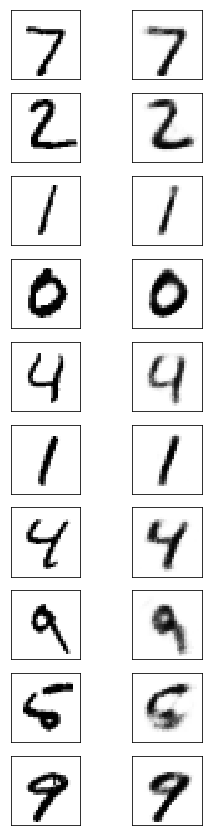

In [4]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
images, labels = mnist.test.images, mnist.test.labels

feed_dict = {sess.graph.get_tensor_by_name(input_signature['inputs'].name): mnist.test.images[:10]}
output = sess.graph.get_tensor_by_name(output_signature['outputs'].name)
results = sess.run(output, feed_dict=feed_dict)

fig = plt.figure(figsize=(4,15))
for i in range(10):
        subplot = fig.add_subplot(10,2,i*2+1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(images[i].reshape((28,28)), vmin=0, vmax=1,
                       cmap=plt.cm.gray_r, interpolation="nearest")
        
        subplot = fig.add_subplot(10,2,i*2+2)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(results[i].reshape((28,28)), vmin=0, vmax=1,
                       cmap=plt.cm.gray_r, interpolation="nearest")

plt.show()

# HTML based prediction tool

In [5]:
input_form = """
<table>
<td style="border-style: none;">
<div style="border: solid 2px #666; width: 143px; height: 144px;">
<canvas width="140" height="140"></canvas>
</div></td>
<td style="border-style: none;">
<button onclick="clear_value()">Clear</button>
</td>
</table>
"""

javascript = """
<script type="text/Javascript">
    var pixels = [];
    for (var i = 0; i < 28*28; i++) pixels[i] = 0
    var click = 0;

    var canvas = document.querySelector("canvas");
    canvas.addEventListener("mousemove", function(e){
        if (e.buttons == 1) {
            click = 1;
            canvas.getContext("2d").fillStyle = "rgb(0,0,0)";
            canvas.getContext("2d").fillRect(e.offsetX, e.offsetY, 8, 8);
            x = Math.floor(e.offsetY * 0.2)
            y = Math.floor(e.offsetX * 0.2) + 1
            for (var dy = 0; dy < 2; dy++){
                for (var dx = 0; dx < 2; dx++){
                    if ((x + dx < 28) && (y + dy < 28)){
                        pixels[(y+dy)+(x+dx)*28] = 1
                    }
                }
            }
        } else {
            if (click == 1) set_value()
            click = 0;
        }
    });
    
    function set_value(){
        var result = ""
        for (var i = 0; i < 28*28; i++) result += pixels[i] + ","
        var kernel = IPython.notebook.kernel;
        kernel.execute("image = [" + result + "]");
    }
    
    function clear_value(){
        canvas.getContext("2d").fillStyle = "rgb(255,255,255)";
        canvas.getContext("2d").fillRect(0, 0, 140, 140);
        for (var i = 0; i < 28*28; i++) pixels[i] = 0
    }
</script>
"""

In [7]:
from IPython.display import HTML
HTML(input_form + javascript)

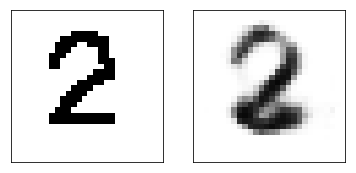

Differnce :41.3310029514


In [8]:
feed_dict = {sess.graph.get_tensor_by_name(input_signature['inputs'].name):[image]}
output = sess.graph.get_tensor_by_name(output_signature['outputs'].name)
results = sess.run(output, feed_dict=feed_dict)

fig = plt.figure(figsize=(6,3))

subplot = fig.add_subplot(1,2,1)
subplot.set_xticks([])
subplot.set_yticks([])
subplot.imshow(np.array(image).reshape((28,28)), vmin=0, vmax=1,
                       cmap=plt.cm.gray_r, interpolation="nearest")
        
subplot = fig.add_subplot(1,2,2)
subplot.set_xticks([])
subplot.set_yticks([])
subplot.imshow(results[0].reshape((28,28)), vmin=0, vmax=1,
                       cmap=plt.cm.gray_r, interpolation="nearest")

plt.show()

loss = tf.reduce_sum(tf.square(results[0] - image))
loss_val = sess.run(loss)
print("Differnce :"+str(loss_val))